In [91]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Importing the data

In [92]:
p2 = pd.read_csv('Data/TTI_Pillar2/DistanceMatrixJaccardOriginPillar2.csv')
sgss = pd.read_csv('Data/TTI_SGSS/DistanceMatrixJaccardOriginSGSS.csv')
css = pd.read_csv('Data/CovidSymptomStudy/JaccardSymptomWide.csv')
cis = pd.read_csv('Data/CommunityInfectionSurvey/DistanceMatrixJaccard.csv')

Name the first column as the symptom columnm.

In [93]:
p2 = p2.rename({p2.columns[0]: 'symptom'}, axis='columns')
sgss = sgss.rename({sgss.columns[0]: 'symptom'}, axis='columns')
css = css.rename({css.columns[0]: 'symptom'}, axis='columns')
cis = cis.rename({cis.columns[0]: 'symptom'}, axis='columns')

Extract the jaccard distance matrices

In [94]:
p2_jaccard = p2.loc[:, p2.columns != 'symptom'].values
sgss_jaccard = sgss.loc[:, sgss.columns != 'symptom'].values
css_jaccard = css.loc[:, css.columns != 'symptom'].values
cis_jaccard = cis.loc[:, cis.columns != 'symptom'].values

Extract the symptom names

In [95]:
p2_symptoms = p2.loc[:, p2.columns == 'symptom']
sgss_symptoms = sgss.loc[:, sgss.columns == 'symptom']
css_symptoms = css.loc[:, css.columns == 'symptom']
cis_symptoms = cis.loc[:, cis.columns == 'symptom']

Each dataset stores the variables with slightly different names. We can join the the symptom_name_category lookup table to get a standardised naming convention for symptoms.

In [96]:
symptom_name_category_lookup = pd.read_csv('Data/Lookups/SymptomNameCategoryLookup.csv')

We need to subset the lookup to get appropiate lookups for each dataset.

In [97]:
ctas_lookup = symptom_name_category_lookup[symptom_name_category_lookup.dataset == 'CTAS']
css_lookup = symptom_name_category_lookup[symptom_name_category_lookup.dataset == 'Zoe']
cis_lookup = symptom_name_category_lookup[symptom_name_category_lookup.dataset == 'ONS']

Join the symptoms to create lookup, and retain only the useful data

In [98]:
p2_symptoms = pd.merge(left = p2_symptoms, right = ctas_lookup, left_on = 'symptom', right_on='symptom_name_raw')[['symptom', 'symptom_id', 'symptom_name_formatted', 'category']]
sgss_symptoms = pd.merge(left = sgss_symptoms, right = ctas_lookup, left_on = 'symptom', right_on='symptom_name_raw')[['symptom', 'symptom_id', 'symptom_name_formatted', 'category']]
css_symptoms = pd.merge(left = css_symptoms, right = css_lookup, left_on = 'symptom', right_on='symptom_name_raw')[['symptom', 'symptom_id', 'symptom_name_formatted', 'category']]
cis_symptoms = pd.merge(left = cis_symptoms, right = cis_lookup, left_on = 'symptom', right_on='symptom_name_raw')[['symptom', 'symptom_id', 'symptom_name_formatted', 'category']]

Create a list containing a list of all the symptom_id's in each datset, and then work out which symptom id's are common across all datasets.

In [99]:
symptom_ids = [
    p2_symptoms.symptom_name_formatted.values,
    sgss_symptoms.symptom_name_formatted.values,
    css_symptoms.symptom_name_formatted.values,
    cis_symptoms.symptom_name_formatted.values
]

shared_ids = symptom_ids[0]
for id_set in symptom_ids:
    shared_ids = np.intersect1d(shared_ids, id_set)

shared_ids

array(['Cough', 'Diarrhoea', 'Fatigue', 'Fever', 'Headache',
       'Muscle ache', 'Sore throat'], dtype=object)

Create a utlity function that produces the mapping between symptoms in different datasets.

In [100]:
def map_symptoms(vector_from, vector_to):
    
    mapping = {}

    for num_from, symptom_id_from in enumerate(vector_from.symptom_name_formatted.values):
        if symptom_id_from in shared_ids:
            for num_to, symptom_id_to in enumerate(vector_to.symptom_name_formatted.values):
                if symptom_id_to == symptom_id_from:
                    mapping[num_from] = num_to

    return mapping

Specify a sequence of datasets, and then create a list of mappings between those datasets.

In [101]:
distance_matrix_list = [p2_jaccard, sgss_jaccard, css_jaccard, cis_jaccard]
relation_dict_list = [map_symptoms(p2_symptoms, sgss_symptoms), map_symptoms(sgss_symptoms, css_symptoms), map_symptoms(css_symptoms, cis_symptoms)]

Perform the alignment

In [102]:
aligned_mapper = umap.AlignedUMAP(
    n_neighbors=[4]*4,
    min_dist = 0.01,
    n_components = 2,
    alignment_window_size=4,
    alignment_regularisation=1e-2,
    learning_rate = 0.1,
    random_state=42,
    metric='precomputed')

# perform the alignment
aligned_mapper.fit(distance_matrix_list, relations = relation_dict_list)

AlignedUMAP(alignment_window_size=4, learning_rate=0.1, metric='precomputed',
            min_dist=0.01, n_neighbors=[4, 4, 4, 4], random_state=42)

In [103]:
# utility function to find create some useable axis
def axis_bounds(embedding):
    
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

Quickly plot the output. We have more advanced plotting code in the R visualisation notebooks that plot points and labels using size and colour, etc.

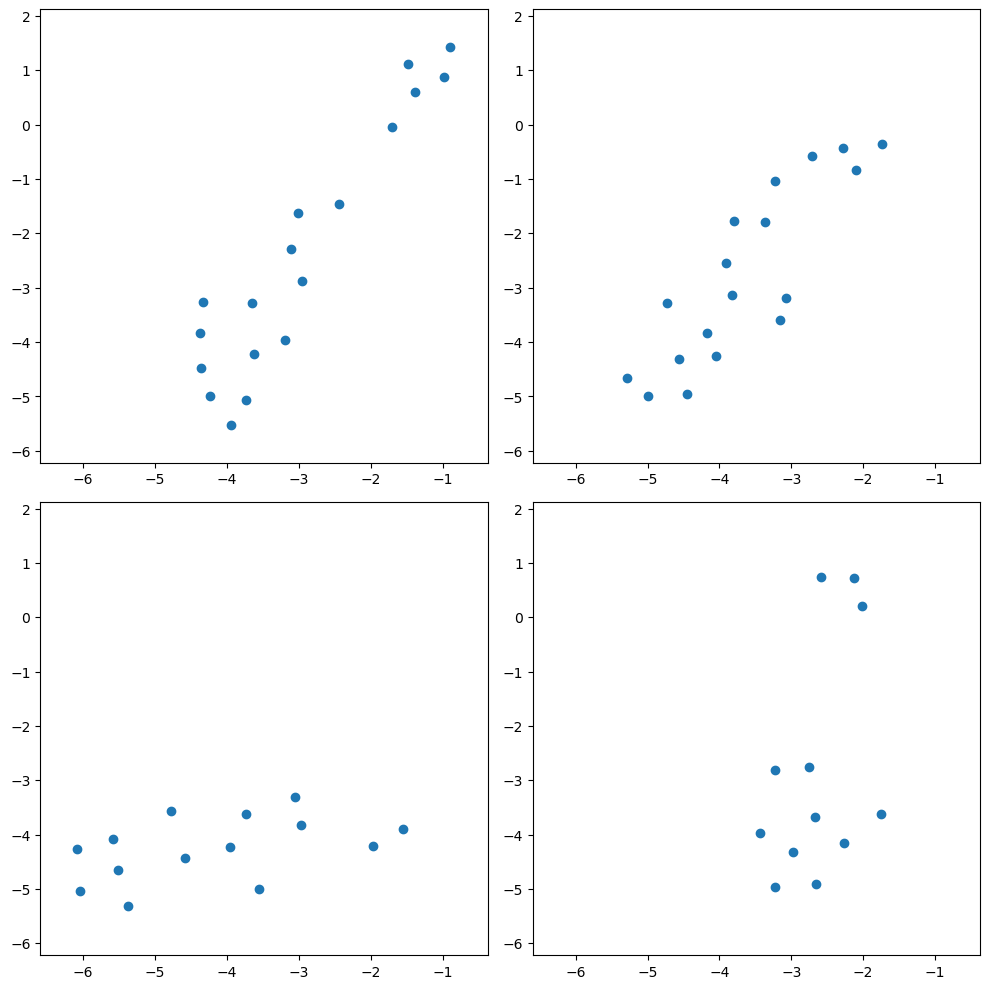

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(*aligned_mapper.embeddings_[i].T)
    ax.axis(ax_bound)
plt.tight_layout()
plt.show()

In [105]:
# saving outputs
p2_embedding = pd.DataFrame(aligned_mapper.embeddings_[0])
sgss_embedding = pd.DataFrame(aligned_mapper.embeddings_[1])
css_embedding = pd.DataFrame(aligned_mapper.embeddings_[2])
cis_embedding = pd.DataFrame(aligned_mapper.embeddings_[3])

In [106]:
p2_embedding[['symptom_name_raw', 'symptom_name_formatted', 'category']] = p2_symptoms[['symptom', 'symptom_name_formatted', 'category']]
sgss_embedding[['symptom_name_raw', 'symptom_name_formatted', 'category']] = sgss_symptoms[['symptom', 'symptom_name_formatted', 'category']]
css_embedding[['symptom_name_raw', 'symptom_name_formatted', 'category']] = css_symptoms[['symptom', 'symptom_name_formatted', 'category']]
cis_embedding[['symptom_name_raw', 'symptom_name_formatted', 'category']] = cis_symptoms[['symptom', 'symptom_name_formatted', 'category']]

In [107]:
p2_embedding.to_csv('Data/Alignments/AlignedUMAP/CoreSymptomAlignment/P2.csv')
sgss_embedding.to_csv('Data/Alignments/AlignedUMAP/CoreSymptomAlignment/SGSS.csv')
css_embedding.to_csv('Data/Alignments/AlignedUMAP/CoreSymptomAlignment/CSS.csv')
cis_embedding.to_csv('Data/Alignments/AlignedUMAP/CoreSymptomAlignment/CIS.csv')